In [1]:


import yaml, torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from sklearn.manifold import TSNE

from tqdm import tqdm

from types import SimpleNamespace
import os, sys


In [2]:
project_dir = './msn'

if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
os.chdir(project_dir)


In [3]:
model_folder = "proto11_embed32_encoder_hsi" 
config_path = os.path.join( 'output',model_folder ,'config.yaml')

with open(config_path, 'r') as f:
        config_dict = yaml.safe_load(f)
        config = SimpleNamespace(**config_dict)

In [4]:
config

namespace(alpha_ema=0.996,
          attn_drop_rate=0.0,
          batch_size=512,
          bwpe=False,
          data_root='./../hsi_airborne/pca/',
          depth=12,
          drop_path_rate=0.0,
          drop_rate=0.0,
          embed_dim=32,
          encoder_type='hsi',
          epoch_stop_prototype=100,
          final_lr=1e-06,
          final_weight_decay=0.05,
          focal_crop_scale=[0.5, 0.6],
          focal_size=[10, 10, 32],
          focal_views=5,
          in_chans=1,
          lambda_reg=1,
          learning_rate=0.001,
          mask_ratio=0.25,
          mlp_ratio=4.0,
          num_epochs=200,
          num_heads=16,
          num_prototipos=11,
          num_workers=8,
          output_dir='./output/proto11_embed32_encoder_hsi',
          patch_size=[5, 5, 8],
          pin_memory=True,
          project_name='hsi-msn',
          rand_crop_scale=[0.8, 1.0],
          rand_size=[20, 20, 32],
          rand_views=5,
          resume_from=None,
          sav

## Load dataset

In [5]:
from src.dataset import init_data
from torch.utils.data import DataLoader


config_dict['shuffle'] = False

dataset = init_data(config_dict)


/home/emap/.pyenv/versions/hsi-msn/lib/python3.10/site-packages/torch/cuda/__init__.py:829: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
0it [00:00, ?it/s]

(512, 1, 32, 20, 20)


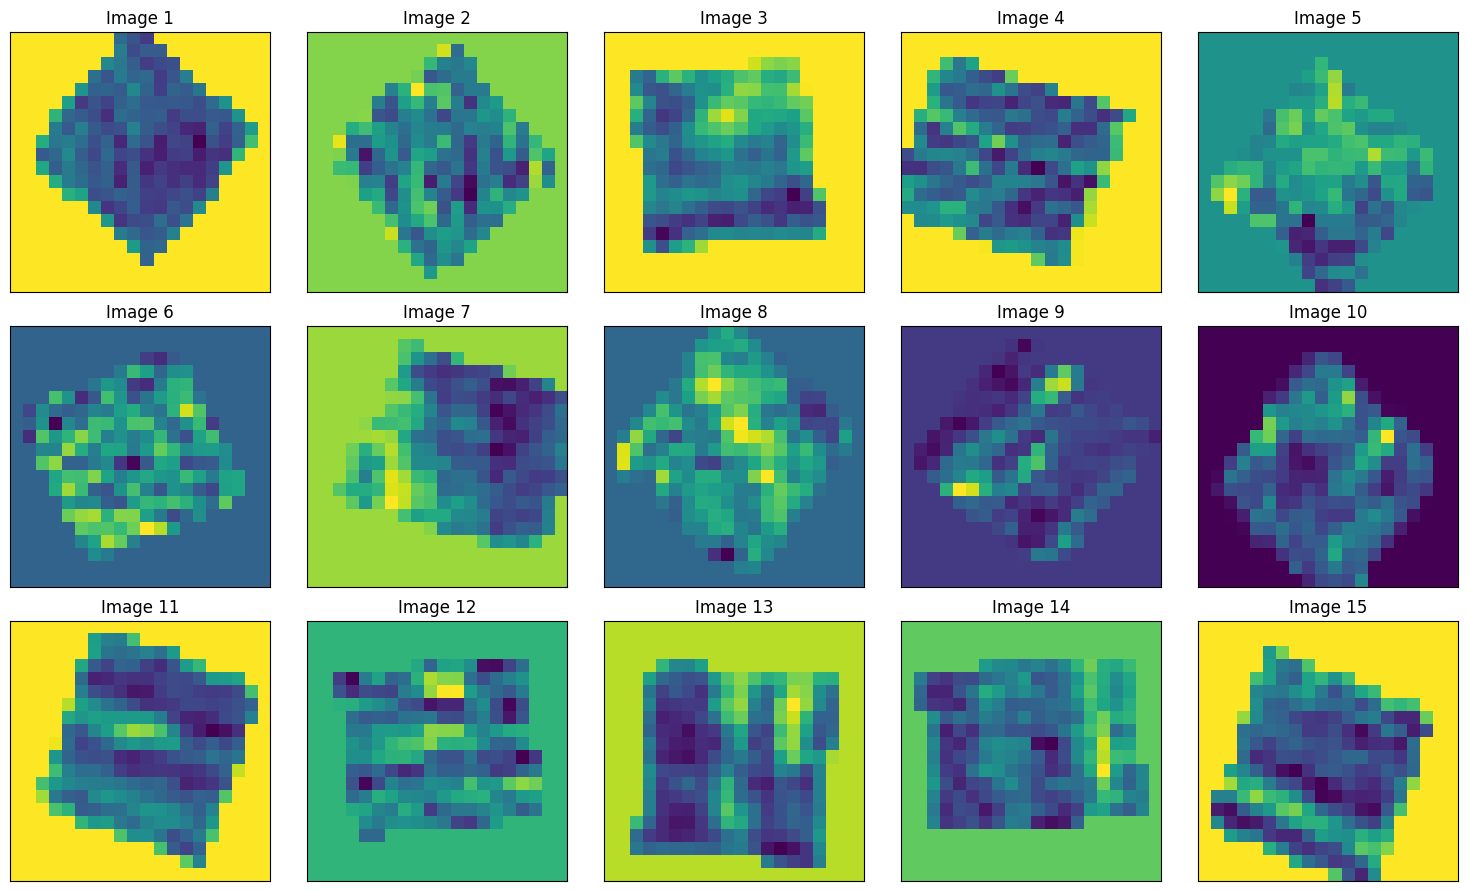

0it [00:01, ?it/s]


In [6]:
# the dataloader returns prisma_data, sentinel_data, airborne_data, 0

# plot 15 images from  airborne data  5x3 grid

#  withe theme

plt.style.use('default')


BAND_NUMBER = 2

for i, views in tqdm(enumerate(dataset)):
    views = [v for v in views]

     # shape [32, 1, 430, 20, 20] view[0] plot
     # view[0] to numpy

    view = views[0].detach().cpu().numpy()

    #plot
    print(view.shape)

    fig, axs = plt.subplots(3, 5, figsize=(15, 9))
    axs = axs.flatten()
    for j in range(15):
        axs[j].imshow(view[j,0, BAND_NUMBER, :, :])
        axs[j].set_title(f'Image {j+1}')
        axs[j].set_xticks([])
        axs[j].set_yticks([])
    plt.tight_layout()
    plt.show()

    break

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#device = "cpu"
from src.hsi_msn import MSNModel

model = MSNModel(config).to(device)


checkpoint_path = f"output/{model_folder}/min_loss_checkpoint.pth"
#checkpoint_path = f"{config.output_dir}/ckpt_epoch_50.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])



Using Vision Transformer HSI as encoder.


<All keys matched successfully>

In [8]:
checkpoint["epoch"]

95

In [9]:
prot = model.prototypes
prot = prot.to(device)
prot = torch.nn.functional.normalize(prot, dim = 0 )
prot.shape

torch.Size([11, 32])

In [10]:
model.eval()

E = torch.empty(0, config.embed_dim).to(device)
F = torch.empty(0, prot.shape[0]).to(device)


count = 0

with torch.no_grad():

    # 10% dos dados
    for i , views in tqdm(enumerate(dataset)):
        count += 1

         # shape [32, 1, 430, 20, 20] view[0] plot
         # view[0] to numpy

        views = views[0].to(device)
        z_views = model.target_encoder(views, mask_ratio=0.0  )

        z_views = torch.nn.functional.normalize(z_views, dim=1)

        E = torch.cat((E, z_views), 0)

        F = torch.cat((F, z_views @ prot.T), 0)

        # if count == 20:
        #     break


4it [00:01,  2.28it/s]


In [11]:
# Concatenate prototypes and latent points
data = torch.cat((E.cpu(), prot.cpu()), dim=0).detach().numpy()

# Apply TSNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(data)

# Separate the results for prototypes and latent points
tsne_E = tsne_results[:E.shape[0]]
tsne_prot = tsne_results[E.shape[0]:]


In [12]:
import torch
import umap
# You may need to install the umap-learn package:
# pip install umap-learn

# Concatenate prototypes and latent points
data = torch.cat((E.cpu(), prot.cpu()), dim=0).detach().numpy()

# Apply UMAP
reducer = umap.UMAP(n_components=2)
umap_results = reducer.fit_transform(data)

# Separate the results for prototypes and latent points
umap_E = umap_results[:E.shape[0]]
umap_prot = umap_results[E.shape[0]:]

/home/emap/.pyenv/versions/hsi-msn/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [13]:
# value count clsuter labels

cluster_labels = torch.argmax(F, dim=1).cpu().numpy()     
cluster_labels = pd.Series(cluster_labels)
cluster_counts = cluster_labels.value_counts().sort_index()
print(cluster_counts) 

0     183
1     143
2     224
3     142
4     223
5     104
6     140
7     181
8     222
9     160
10    154
Name: count, dtype: int64


In [14]:
# read train_gt.csv

train_gt_path = os.path.join( './../train_gt.csv')
train_gt = pd.read_csv(train_gt_path)


train_gt = train_gt[0:len(E)]

In [15]:
len(train_gt), len(E)

(1876, 1876)

In [16]:
train_gt

,sample_index,B,Cu,Zn,Fe,S,Mn
0,0,0.8,2.1,5.0,186.6,12.078640,110.7
1,1,0.6,3.5,7.3,255.6,12.199673,75.7
2,2,0.5,2.1,2.3,204.0,65.882013,87.1
3,3,0.8,1.9,3.3,165.6,31.942712,56.0
4,4,0.5,2.4,5.8,419.9,35.970698,65.1
...,...,...,...,...,...,...,...
1871,1871,0.6,2.6,2.6,225.4,31.778477,99.9
1872,1872,0.5,2.4,3.0,204.2,30.832575,94.2
1873,1873,0.6,2.6,6.1,298.9,10.246492,64.3
1874,1874,0.8,1.8,6.0,184.6,10.098610,125.3


In [17]:
# classificar os dados como high e low based on quartis
Q1 = train_gt.quantile(0.25)
Q3 = train_gt.quantile(0.75)
train_gt_class = pd.DataFrame()
for col in train_gt.columns:
    if col != 'sample_index':
        train_gt_class[col] = pd.cut(train_gt[col], bins=[-np.inf, Q1[col], Q3[col], np.inf], labels=[0,1,2])

train_gt_class

,B,Cu,Zn,Fe,S,Mn
0,1,0,1,1,0,2
1,0,2,2,2,0,1
2,0,0,0,1,2,1
3,1,0,0,0,1,0
4,0,1,1,2,2,0
...,...,...,...,...,...,...
1871,0,1,0,1,1,1
1872,0,1,0,1,1,1
1873,0,1,2,2,0,0
1874,1,0,1,1,0,2


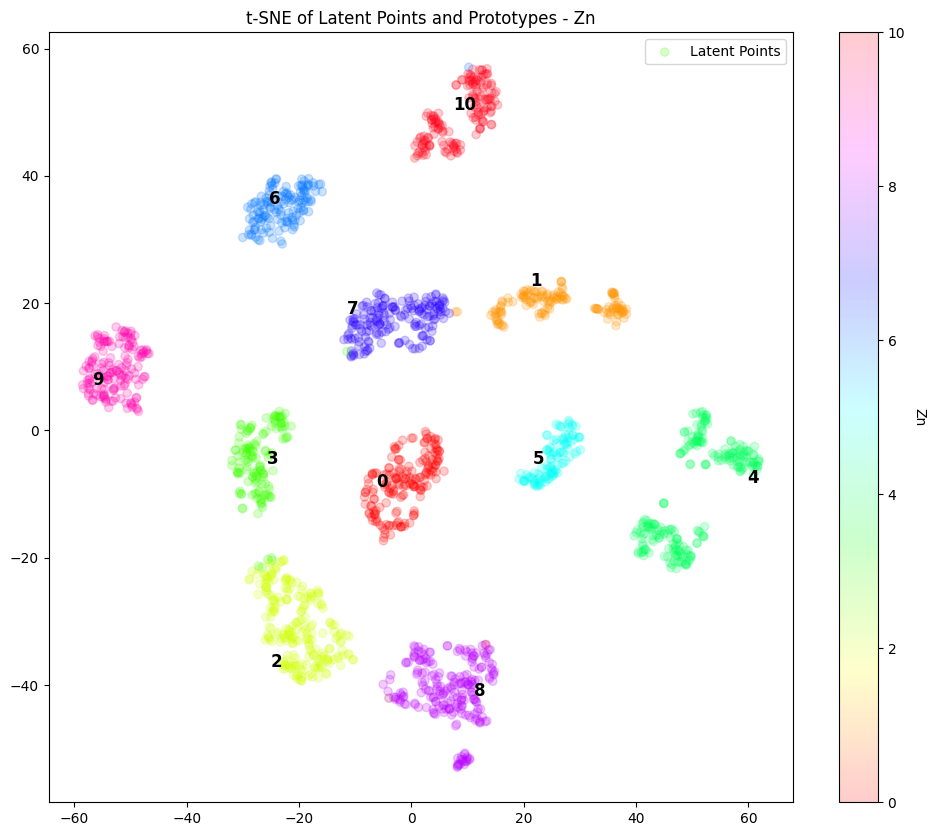

In [18]:


elemento = 'Zn'

# # # Plotar os resultados do t-SNE
values = train_gt[elemento]

# clip cluster labels percentile
lower_bound = np.percentile(values, 5)
upper_bound = np.percentile(values, 95)
values = np.clip(values, lower_bound, upper_bound)

plt.figure(figsize=(12, 10))

# quero um cmap pra classes 
# Use 'c' para o mapeamento de cores e guarde o objeto do scatter plot
scatter = plt.scatter(tsne_E[:, 0], tsne_E[:, 1], c=cluster_labels, cmap='hsv', label='Latent Points', alpha=0.2)

# # # Adiciona a barra de cores and title
cbar = plt.colorbar(scatter)
cbar.set_label(elemento, rotation=270, labelpad=15) # Adiciona um rótulo à barra de cores



# Adiciona os protótipos ao gráfico
for i, (x, y) in enumerate(tsne_prot):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center', weight='bold')

plt.legend()
plt.title("t-SNE of Latent Points and Prototypes - {elemento}".format(elemento=elemento))

# title colorbar label
cbar.set_label(elemento, rotation=270, labelpad=15)

# Salva a figura em um arquivo
plt.savefig('tsne_plot.png')

Salvando a imagem em 'tsne_grid_3x2.png'


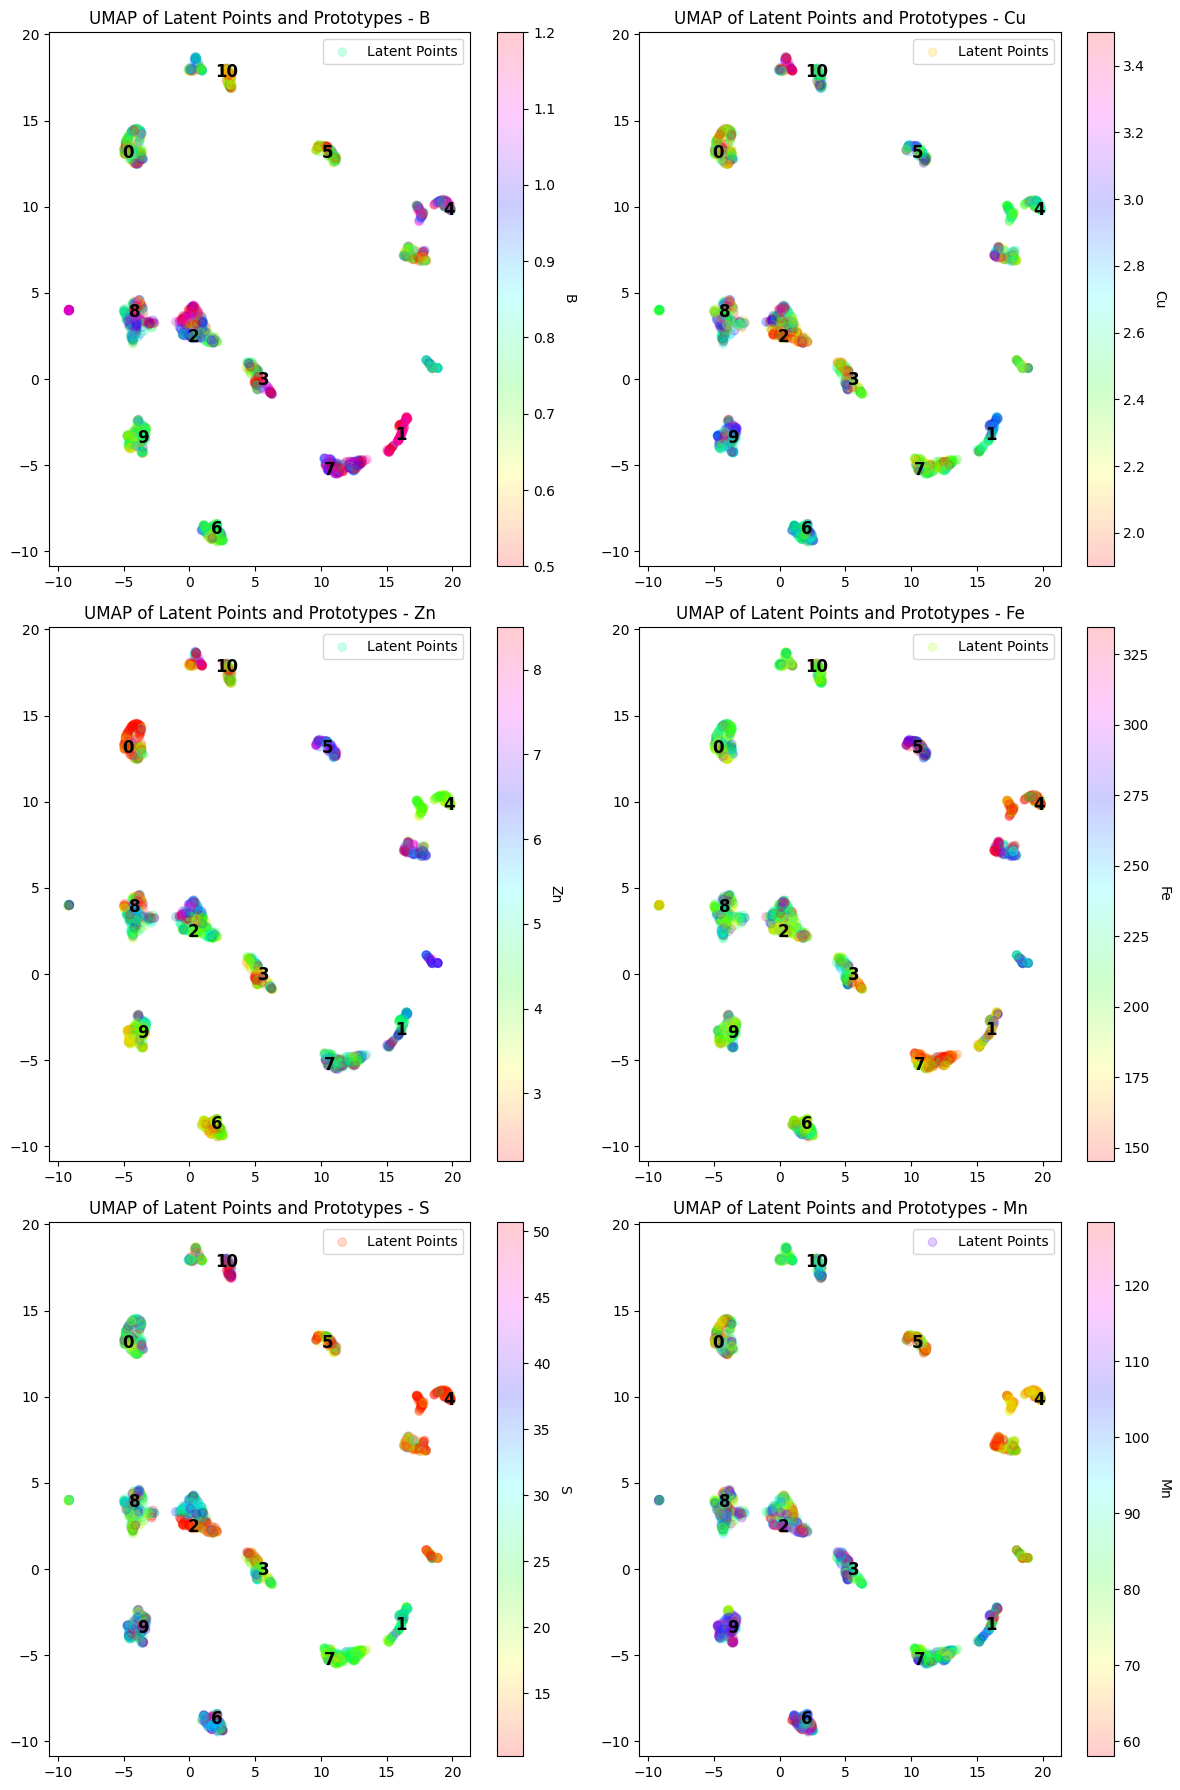

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd




# 1. Lista de elementos que você quer plotar
elementos = ['B', 'Cu', 'Zn', 'Fe', 'S', 'Mn']

# 2. Criar a grade de subplots (3 linhas, 2 colunas)
# Ajustei o figsize para (12, 18) para dar um bom espaço para cada plot (6x6)
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# 3. "Achatar" o array de eixos (de 3x2 para 6x1) para facilitar o loop
# Isso transforma 'axes' de uma matriz 2D para um array 1D
axes = axes.flatten()

# 4. Loop pelos elementos e eixos correspondentes
# O 'zip' junta as duas listas: (axes[0], 'B'), (axes[1], 'Cu'), ...
for ax, elemento in zip(axes, elementos):
    
    # Obter os valores para o elemento atual
    values = train_gt[elemento]

    # Clipar os valores pelo percentil
    lower_bound = np.percentile(values, 5)
    upper_bound = np.percentile(values, 95)
    values = np.clip(values, lower_bound, upper_bound)

    # Plotar os resultados do t-SNE no eixo (ax) atual
    # Note que mudamos de 'plt.scatter' para 'ax.scatter'
    scatter = ax.scatter(
        umap_E[:, 0], 
        umap_E[:, 1], 
        c=values, 
        cmap='hsv', 
        label='Latent Points', 
        alpha=0.2
    )

    # Adicionar a barra de cores
    # Note que usamos fig.colorbar(..., ax=ax) para associar ao subplot correto
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
    cbar.set_label(elemento, rotation=270, labelpad=15)

    # Adicionar os protótipos ao gráfico
    # Note que mudamos de 'plt.text' para 'ax.text'
    for i, (x, y) in enumerate(umap_prot):
        ax.text(x, y, i, color='black', fontsize=12, ha='center', va='center', weight='bold')

    # Definir título e legenda para o subplot específico
    ax.legend()
    ax.set_title(f"UMAP of Latent Points and Prototypes - {elemento}")

# 5. Ajustar o layout para evitar sobreposição de títulos/rótulos
plt.tight_layout()

# 6. Salvar a figura inteira
print("Salvando a imagem em 'tsne_grid_3x2.png'")
plt.savefig("tsne_grid_3x2.png", dpi=150, bbox_inches='tight')

# plt.show() # Descomente se quiser exibir a imagem interativamente

In [20]:
# SAVE ON  a specifc folder
# downstream folder

downstream_folder = os.path.join('downstream' )
os.makedirs(downstream_folder, exist_ok=True)
downstream_folder_model = os.path.join(downstream_folder, model_folder)
os.makedirs(downstream_folder_model, exist_ok=True)

Salvando a imagem em 'tsne_grid_3x2.png'


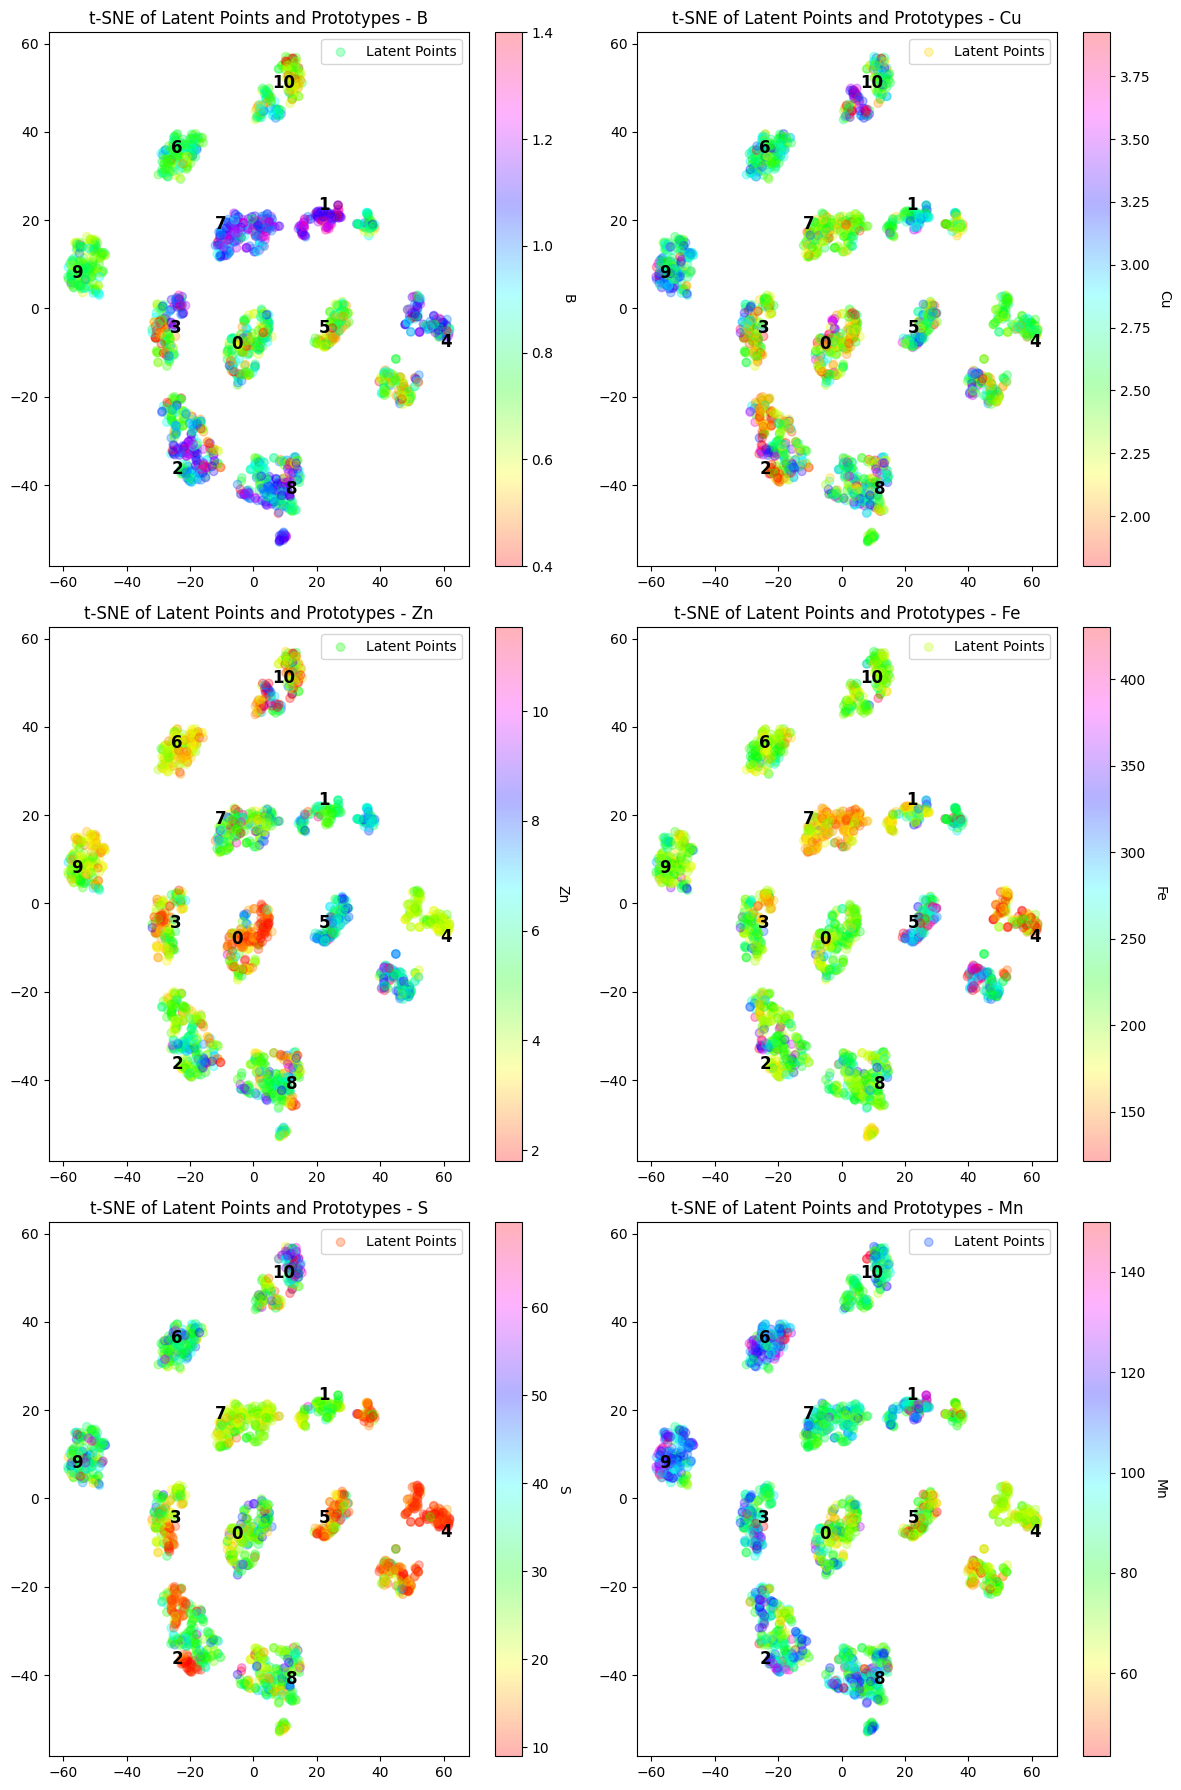

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd




# 1. Lista de elementos que você quer plotar
elementos = ['B', 'Cu', 'Zn', 'Fe', 'S', 'Mn']

# 2. Criar a grade de subplots (3 linhas, 2 colunas)
# Ajustei o figsize para (12, 18) para dar um bom espaço para cada plot (6x6)
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# 3. "Achatar" o array de eixos (de 3x2 para 6x1) para facilitar o loop
# Isso transforma 'axes' de uma matriz 2D para um array 1D
axes = axes.flatten()

# 4. Loop pelos elementos e eixos correspondentes
# O 'zip' junta as duas listas: (axes[0], 'B'), (axes[1], 'Cu'), ...
for ax, elemento in zip(axes, elementos):
    
    # Obter os valores para o elemento atual
    values = train_gt[elemento]

    # Clipar os valores pelo percentil
    lower_bound = np.percentile(values, 1)
    upper_bound = np.percentile(values, 99)
    values = np.clip(values, lower_bound, upper_bound)

    # Plotar os resultados do t-SNE no eixo (ax) atual
    # Note que mudamos de 'plt.scatter' para 'ax.scatter'
    scatter = ax.scatter(
        tsne_E[:, 0], 
        tsne_E[:, 1], 
        c=values, 
        cmap='hsv', 
        label='Latent Points', 
        alpha=0.3
    )

    # Adicionar a barra de cores
    # Note que usamos fig.colorbar(..., ax=ax) para associar ao subplot correto
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
    cbar.set_label(elemento, rotation=270, labelpad=15)

    # Adicionar os protótipos ao gráfico
    # Note que mudamos de 'plt.text' paras 'ax.text'
    for i, (x, y) in enumerate(tsne_prot):
        ax.text(x, y, i, color='black', fontsize=12, ha='center', va='center', weight='bold')

    # Definir título e legenda para o subplot específico
    ax.legend()
    ax.set_title(f"t-SNE of Latent Points and Prototypes - {elemento}")

# 5. Ajustar o layout para evitar sobreposição de títulos/rótulos
plt.tight_layout()

# 6. Salvar a figura inteira
print("Salvando a imagem em 'tsne_grid_3x2.png'")
plt.savefig(downstream_folder_model + "/tsne_grid_3x2.png", dpi=150, bbox_inches='tight')

Salvando a imagem em 'tsne_grid_3x2_classes.png'


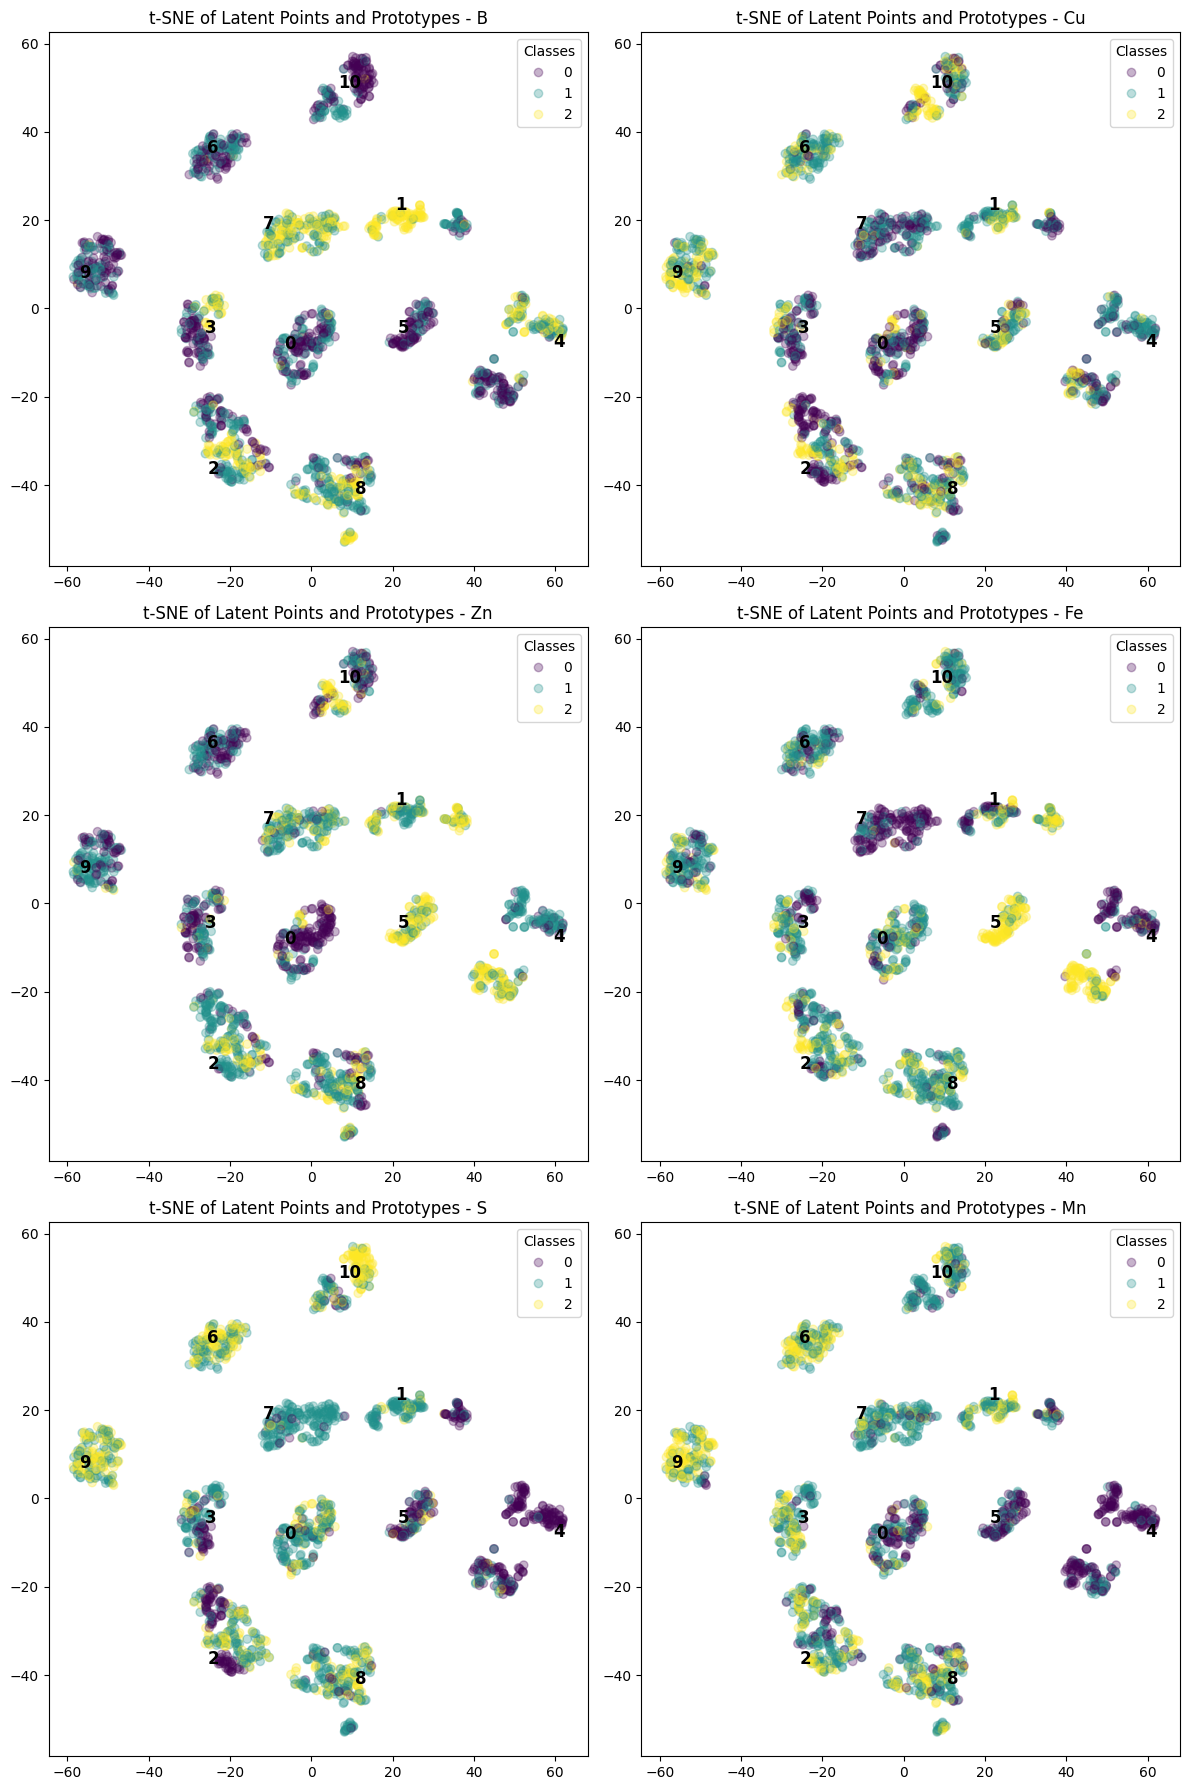

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd




# 1. Lista de elementos que você quer plotar
elementos = ['B', 'Cu', 'Zn', 'Fe', 'S', 'Mn']

# 2. Criar a grade de subplots (3 linhas, 2 colunas)
# Ajustei o figsize para (12, 18) para dar um bom espaço para cada plot (6x6)
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# 3. "Achatar" o array de eixos (de 3x2 para 6x1) para facilitar o loop
# Isso transforma 'axes' de uma matriz 2D para um array 1D
axes = axes.flatten()

# 4. Loop pelos elementos e eixos correspondentes
# O 'zip' junta as duas listas: (axes[0], 'B'), (axes[1], 'Cu'), ...
for ax, elemento in zip(axes, elementos):
    
    # Obter os valores para o elemento atual
    values = train_gt_class[elemento]

    # Plotar os resultados do t-SNE no eixo (ax) atual
    # Note que mudamos de 'plt.scatter' para 'ax.scatter'
    scatter = ax.scatter(
        tsne_E[:, 0], 
        tsne_E[:, 1], 
        c=values, 
        label='Latent Points', 
        alpha=0.3
    )

    # add a legend for classes
    handles, labels = scatter.legend_elements(prop="colors")
    ax.legend(handles, labels, title="Classes")
    

    # Adicionar os protótipos ao gráfico
    # Note que mudamos de 'plt.text' paras 'ax.text'
    for i, (x, y) in enumerate(tsne_prot):
        ax.text(x, y, i, color='black', fontsize=12, ha='center', va='center', weight='bold')

    # Definir título e legenda para o subplot específico
    
    ax.set_title(f"t-SNE of Latent Points and Prototypes - {elemento}")

# 5. Ajustar o layout para evitar sobreposição de títulos/rótulos
plt.tight_layout()

# 6. Salvar a figura inteira
print("Salvando a imagem em 'tsne_grid_3x2_classes.png'")
plt.savefig(downstream_folder_model + "/tsne_grid_3x2_classes.png", dpi=150, bbox_inches='tight')

In [23]:
train_gt.describe()

,sample_index,B,Cu,Zn,Fe,S,Mn
count,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000,1876.000000
mean,937.500000,0.853838,2.587100,4.849147,216.308955,26.473431,89.394563
std,541.698871,0.234609,0.454423,2.032059,59.299509,12.906335,21.714706
min,0.000000,0.300000,1.600000,1.500000,97.300000,6.713378,21.300000
25%,468.750000,0.700000,2.300000,3.500000,179.200000,17.100570,74.000000
50%,937.500000,0.800000,2.500000,4.500000,204.050000,24.871994,87.400000
75%,1406.250000,1.000000,2.800000,6.000000,237.225000,32.188295,102.900000
max,1875.000000,1.900000,4.300000,14.400000,481.700000,96.809265,167.600000


In [24]:

# elemento = 'Zn' 


# # # Plotar os resultados do t-SNE
# values = train_gt[elemento]

# # clip cluster labels percentile
# lower_bound = np.percentile(values, 5)
# upper_bound = np.percentile(values, 95)
# values = np.clip(values, lower_bound, upper_bound)




# plt.figure(figsize=(12, 20))

# # 2 plots 

# # subplot 2 columns 1 row
# plt.figure(figsize=(12, 10))


# fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# axes[0].scatter(umap_E[:, 0], umap_E[:, 1], c=cluster_labels, cmap='hsv', label='Latent Points', alpha=0.2)

# axes[1].scatter(umap_E[:, 0], umap_E[:, 1], c=values, cmap='hsv', label='Latent Points', alpha=0.2)




# # Adiciona os protótipos ao gráfico
# for i, (x, y) in enumerate(umap_prot):
#     axes[0].text(x, y, i, color='black', fontsize=12, ha='center', va='center', weight='bold')
#     axes[1].text(x, y, i, color='black', fontsize=12, ha='center', va='center', weight='bold')

# # add cbar to axes[1]
# cbar = plt.colorbar(scatter, ax=axes[1])
# cbar.set_label(elemento, rotation=270, labelpad=15) # Adicion

# # Salva a figura em um arquivo
# plt.savefig('umap_plot.png')


In [25]:
# add cluster labels to train_gt dataframe
train_gt['cluster_label'] = cluster_labels

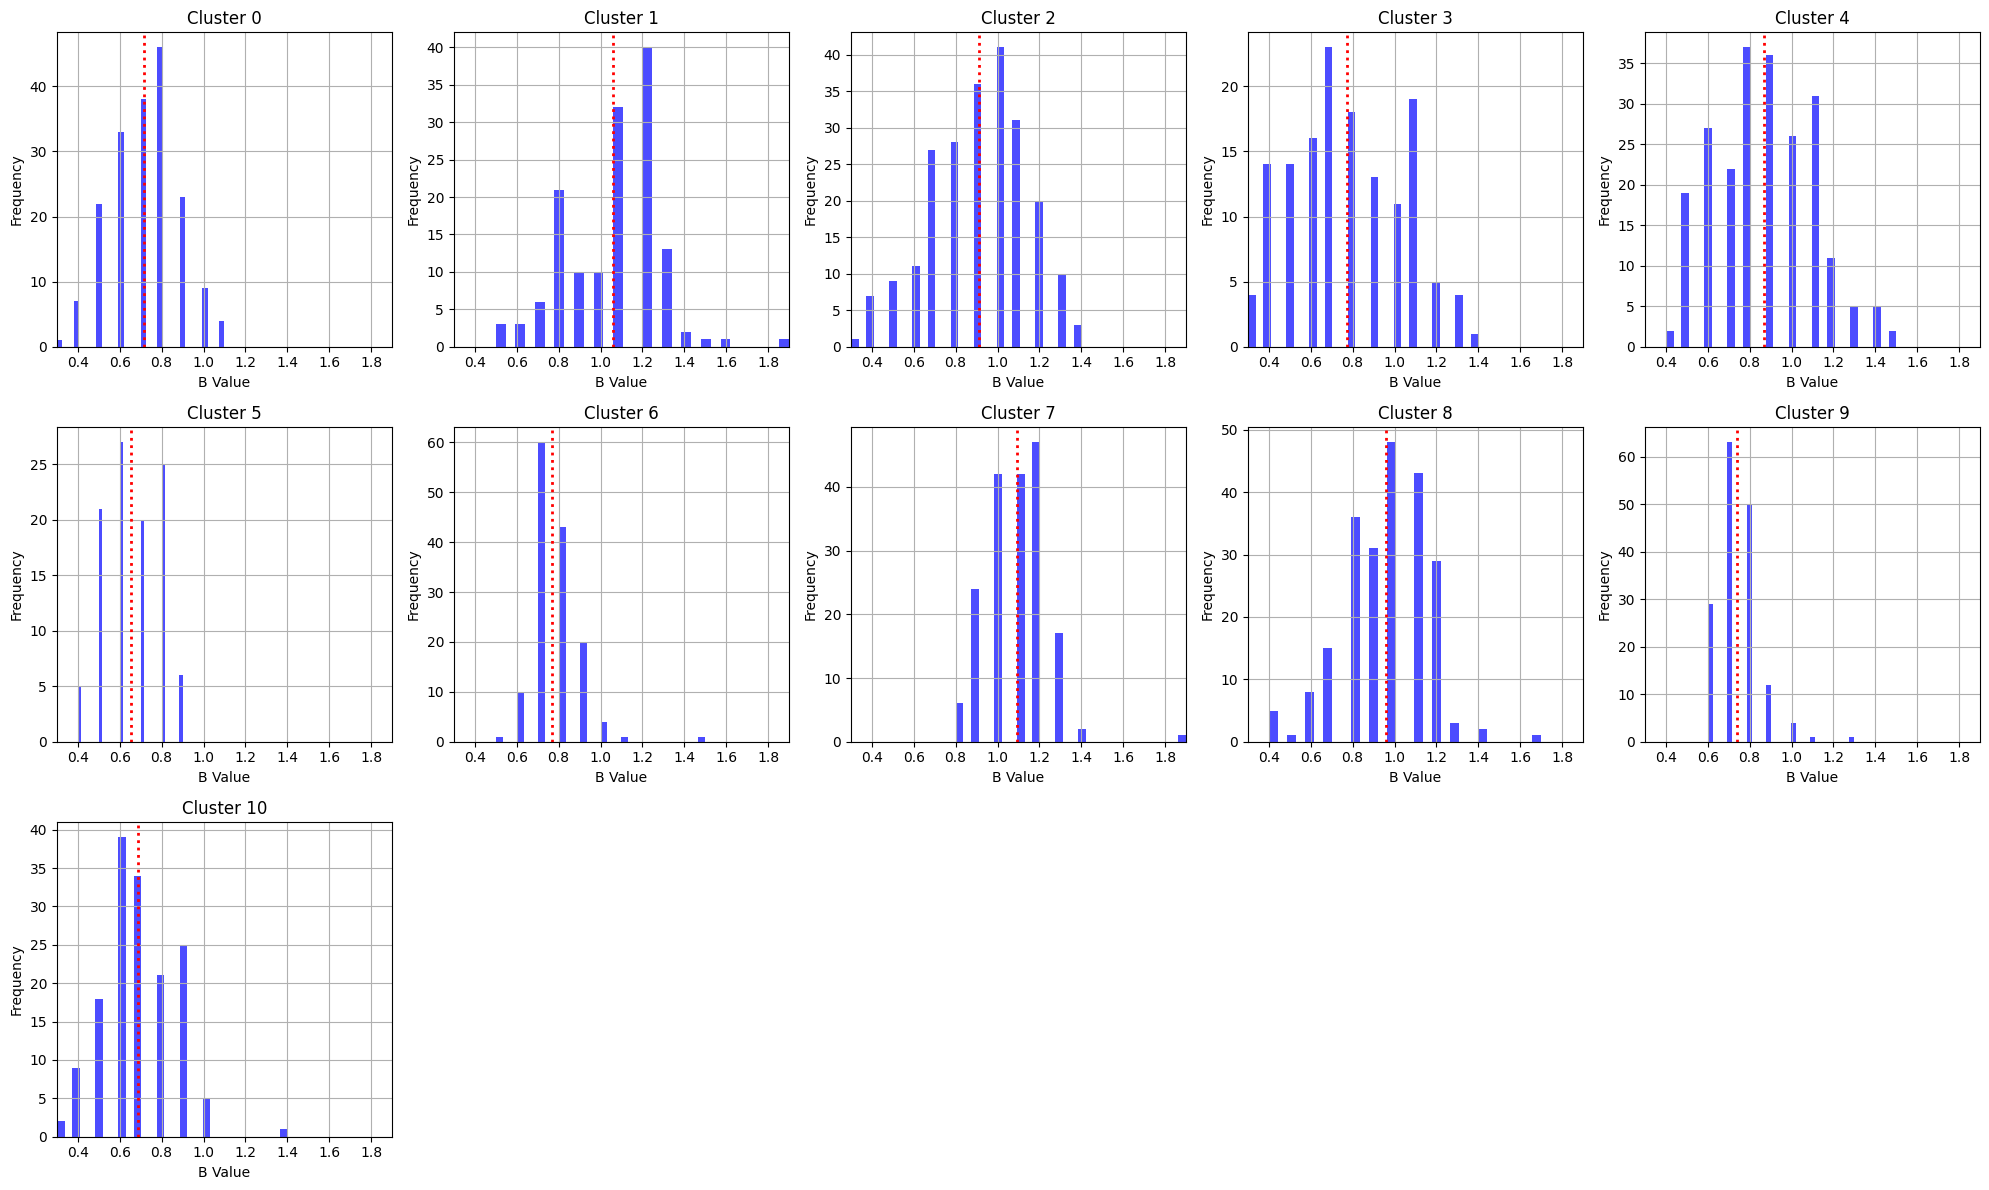

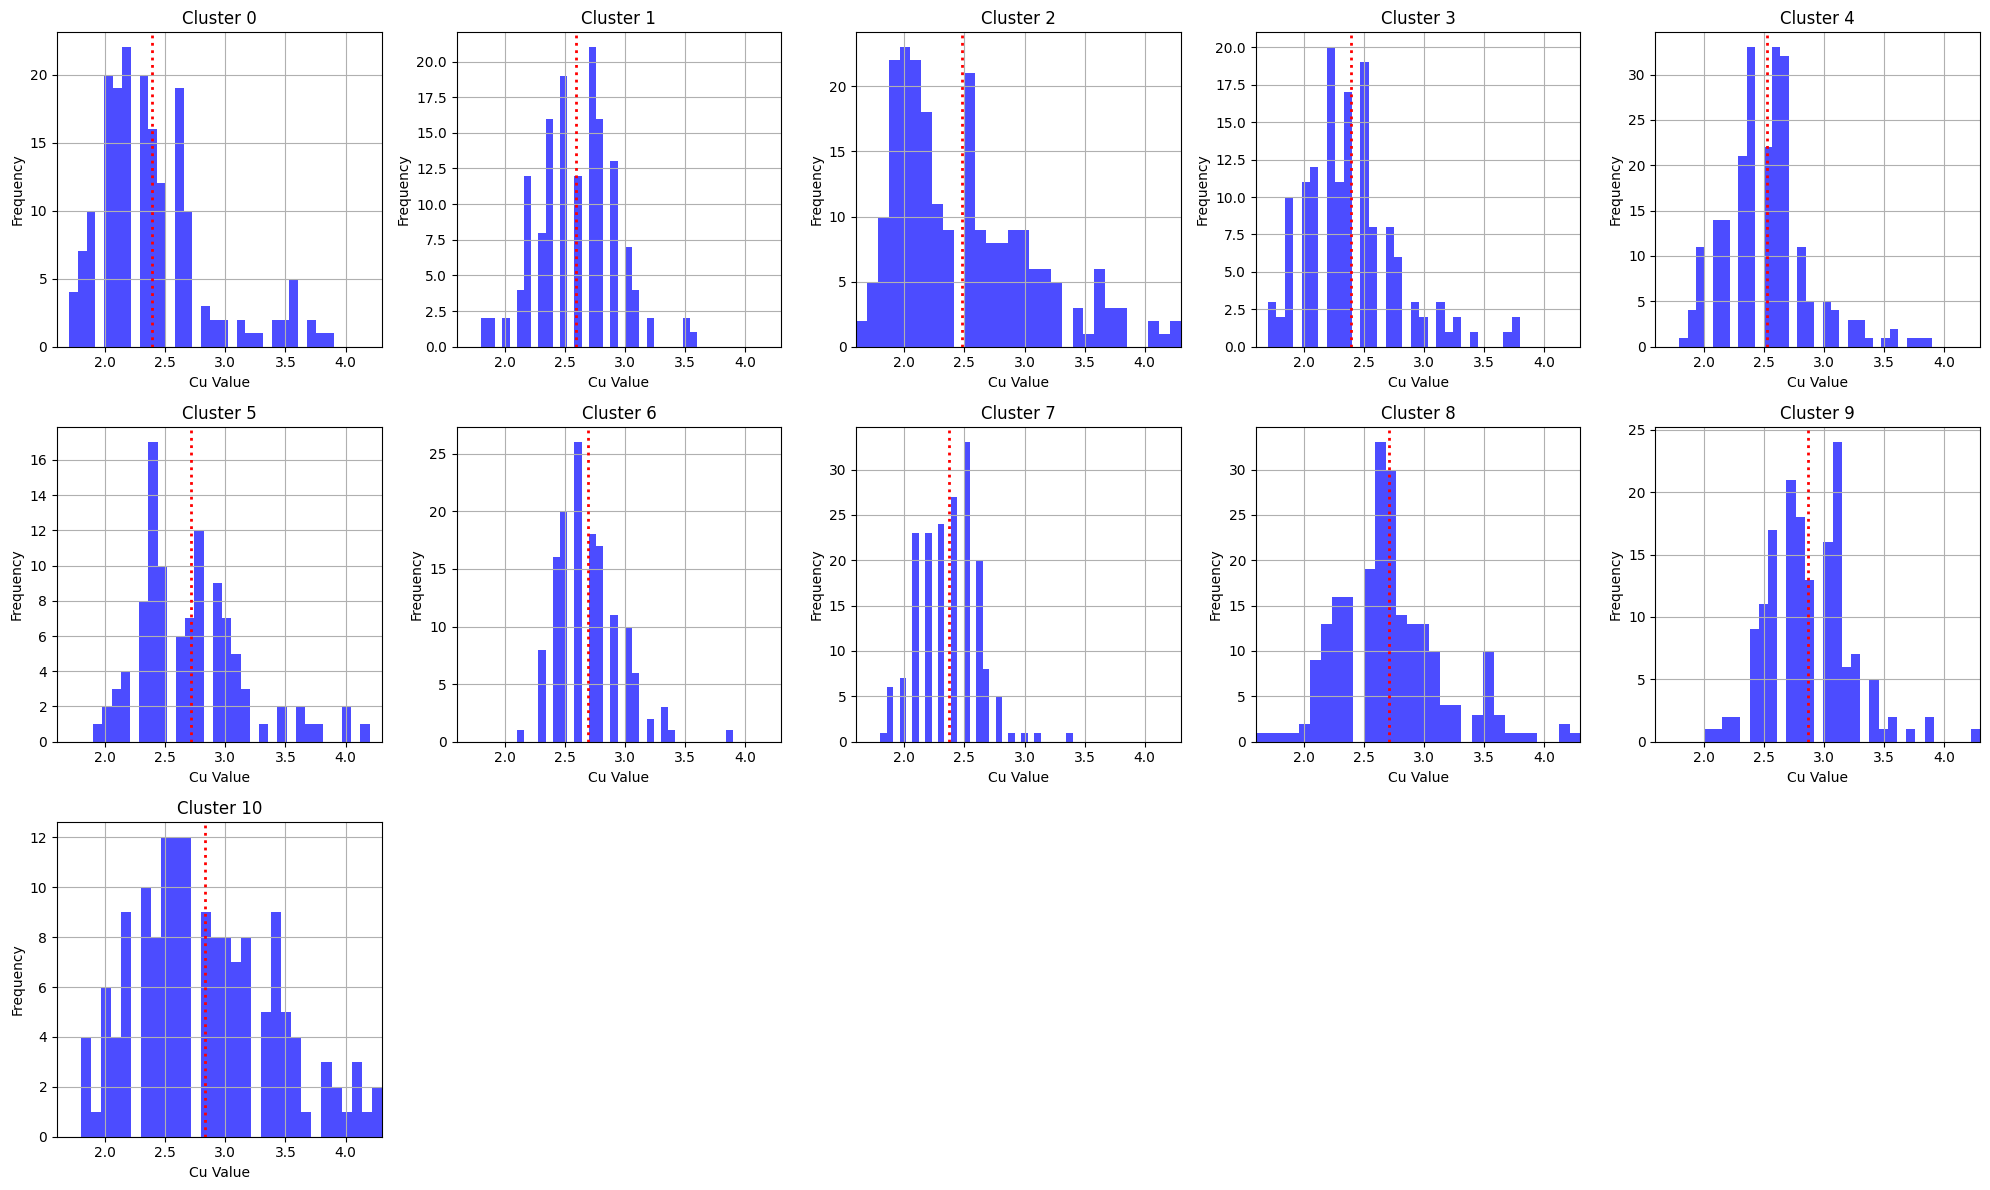

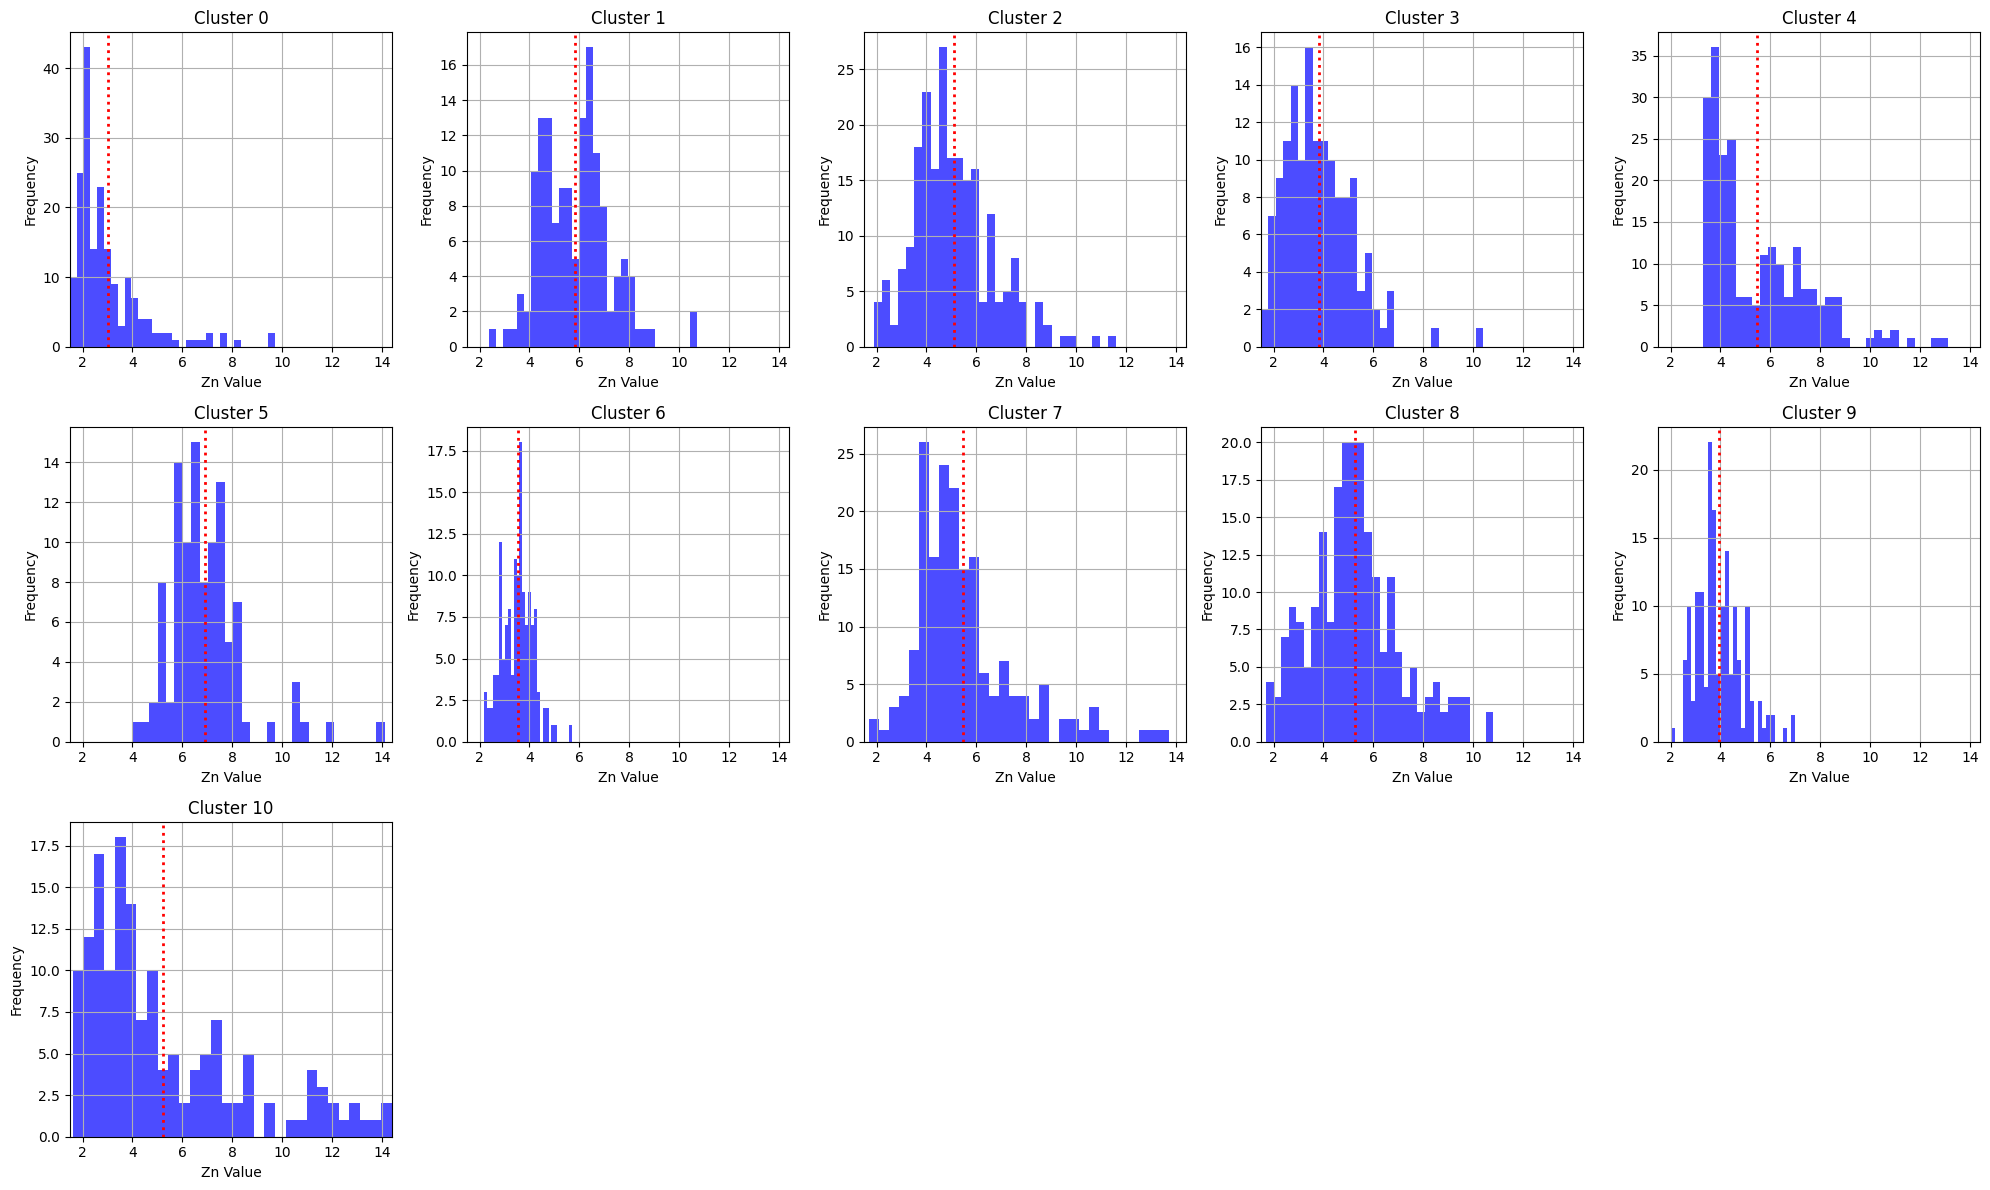

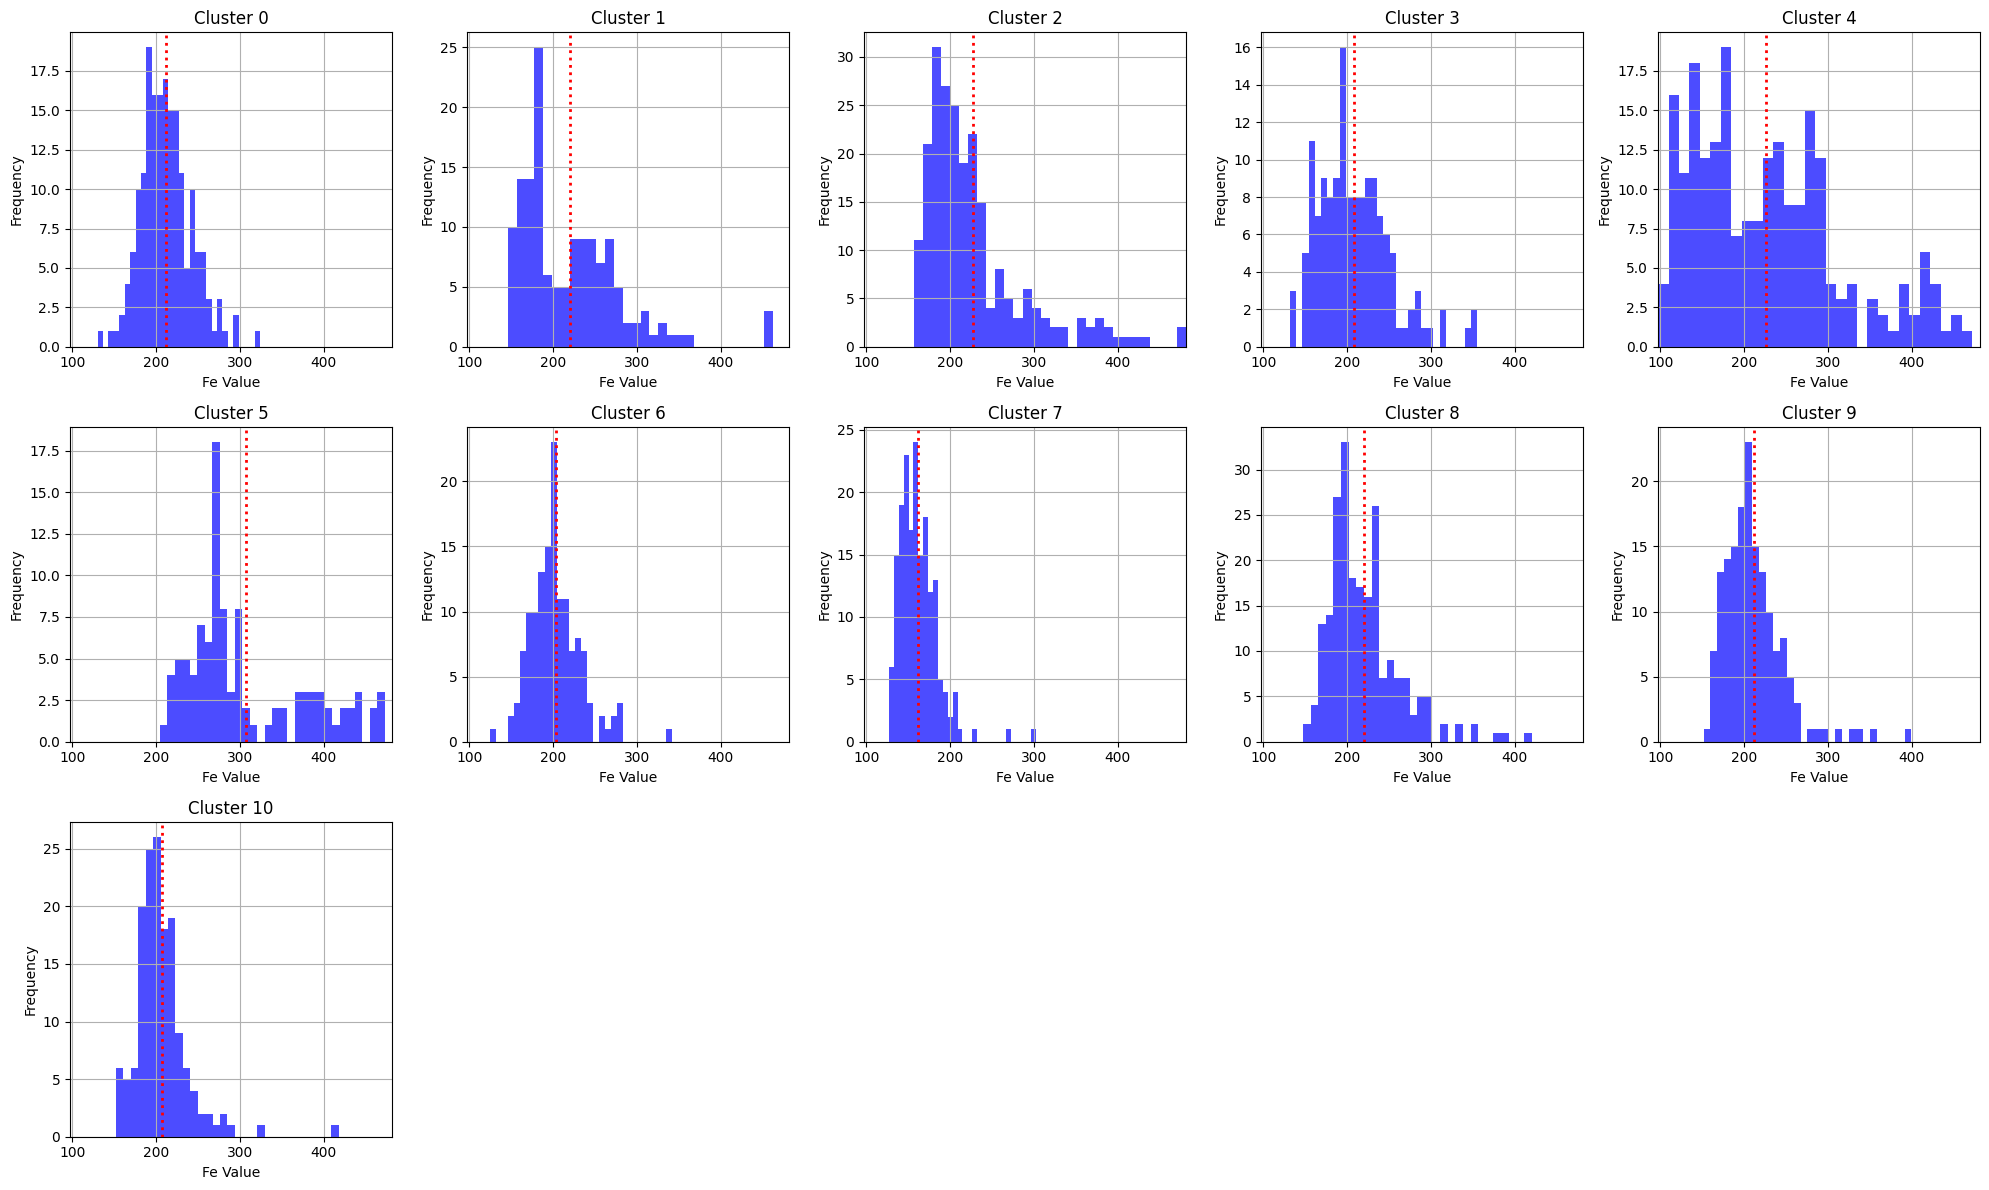

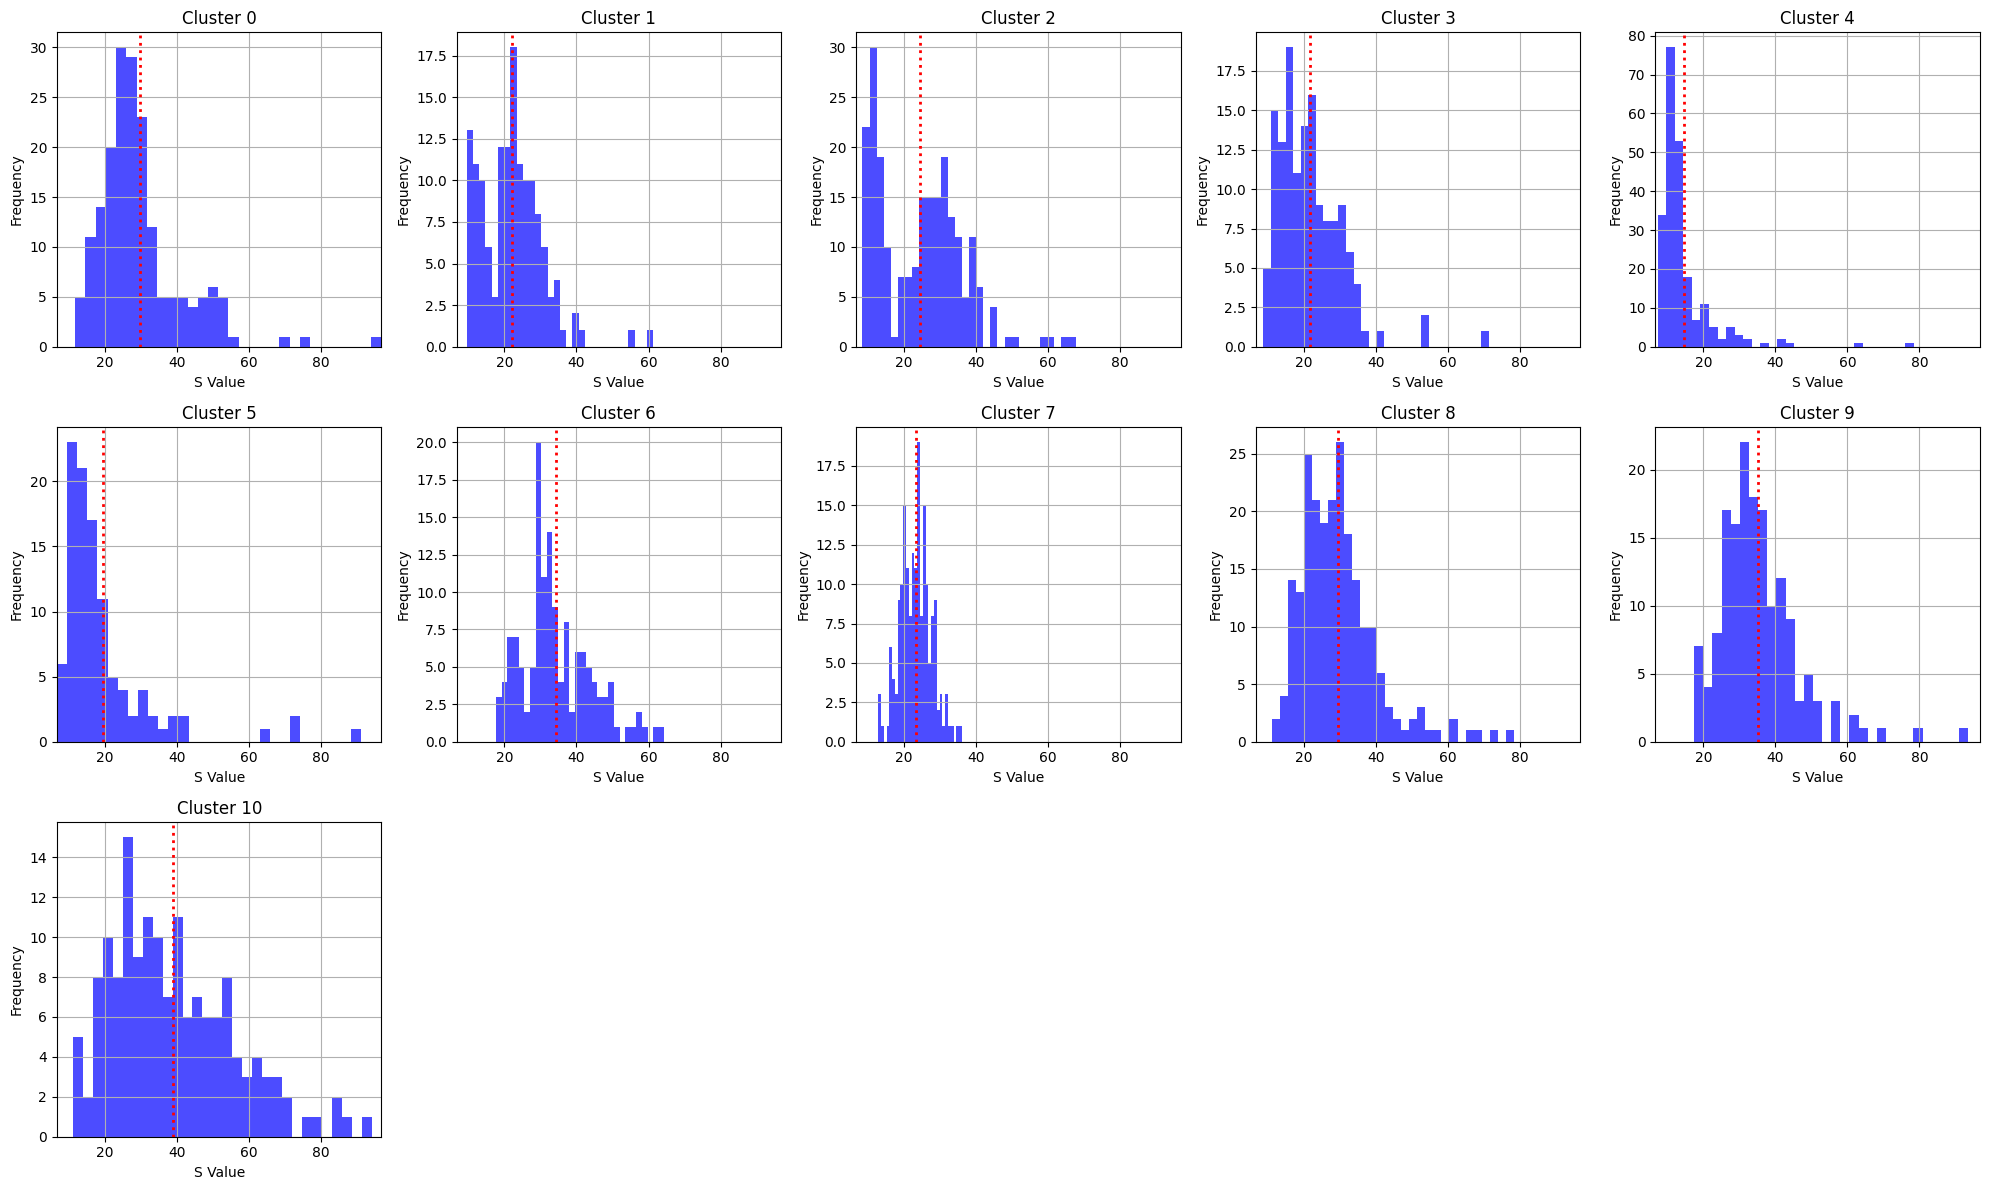

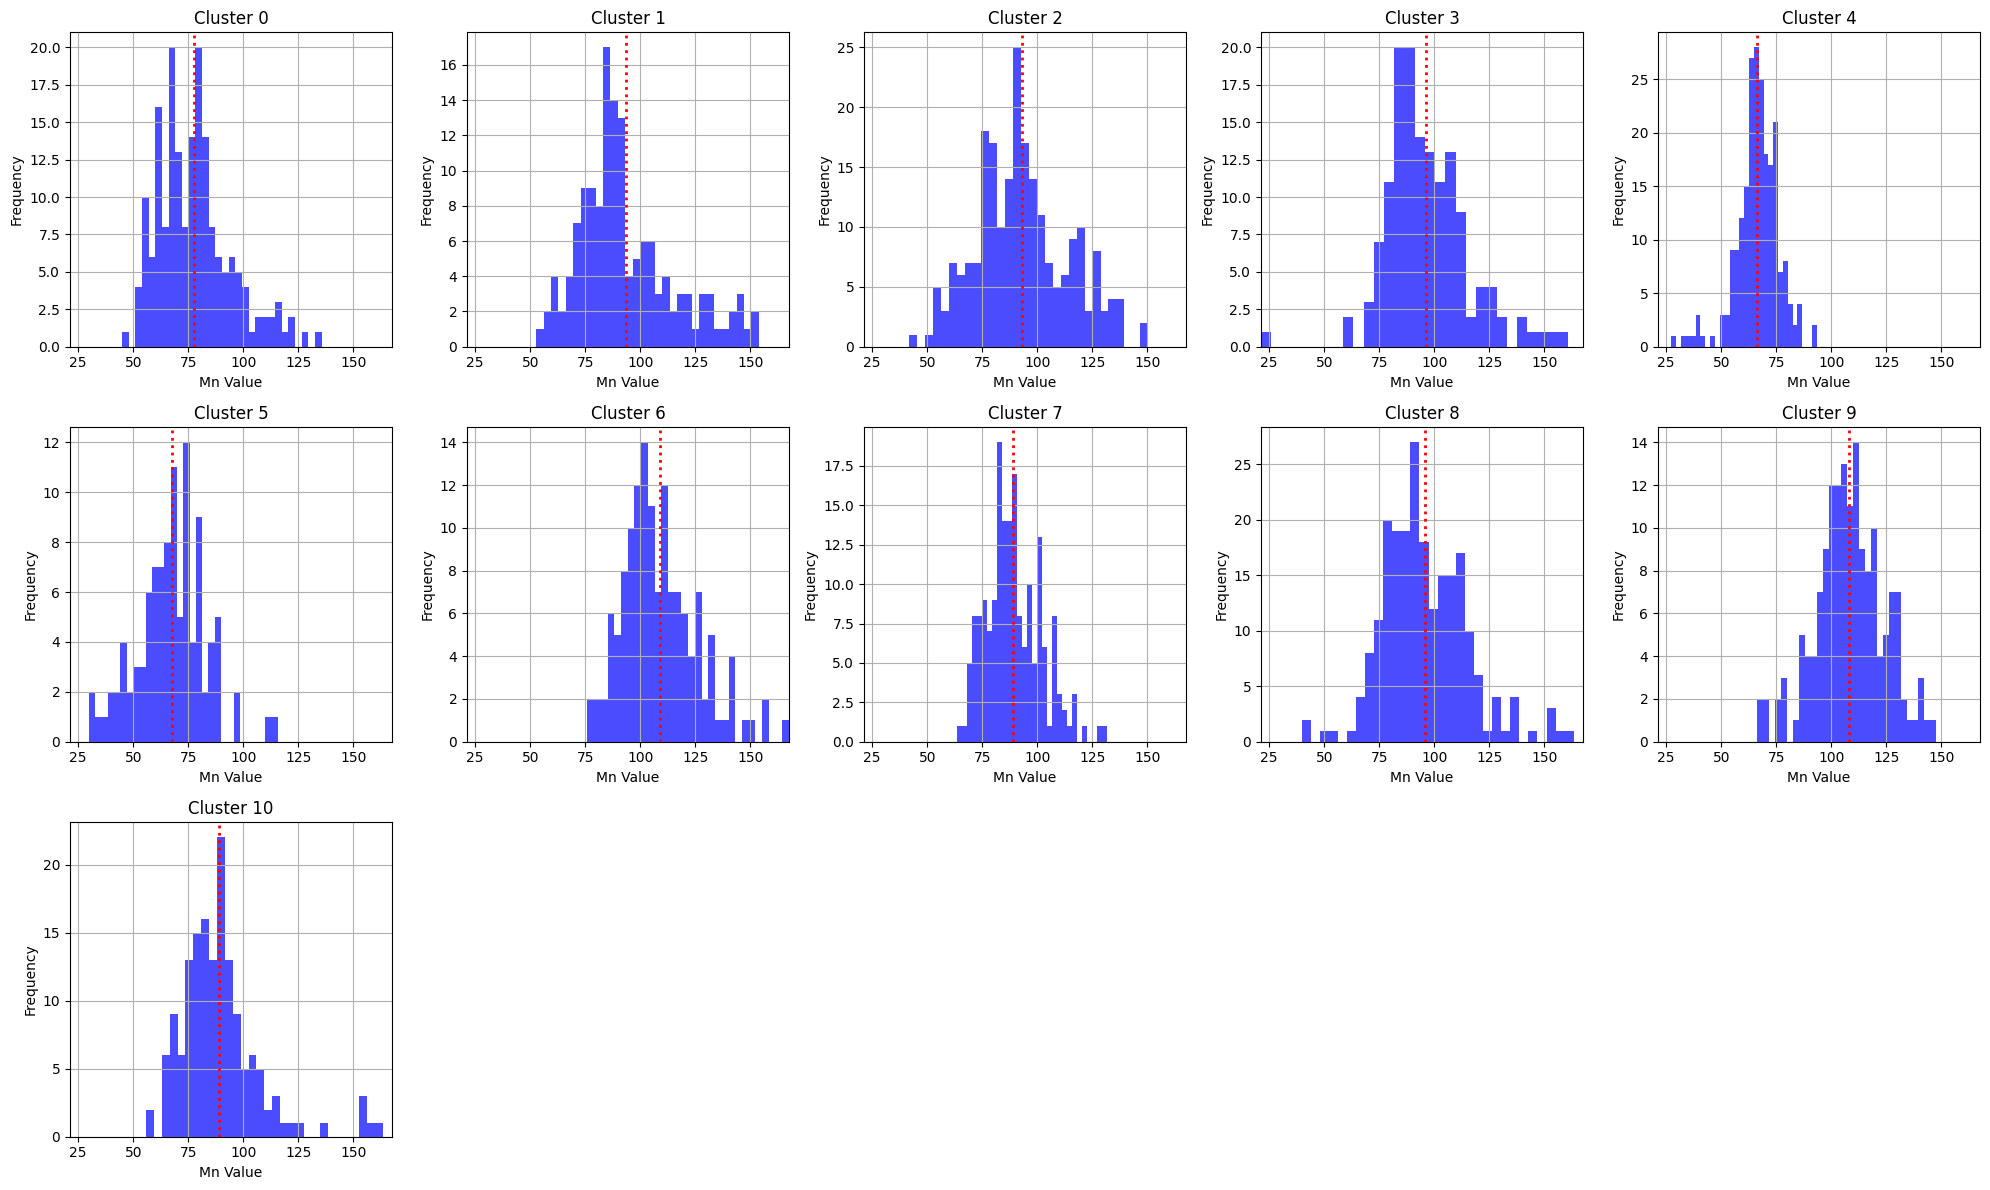

In [26]:
import matplotlib.pyplot as plt
import numpy as np # Importado para o ceil

# create histogram folder in downstream_folder_model
histogram_folder = os.path.join(downstream_folder_model, 'histograms')
os.makedirs(histogram_folder, exist_ok=True)

# all six elements and save histograms for each element
elementos = ['B', 'Cu', 'Zn', 'Fe', 'S', 'Mn']

for elemento in elementos:
    # Your existing code for plotting histograms goes here
    pass

    # --- Suas definições (assumindo que 'train_gt' e 'elemento' existem) ---
    cluster_limits = {'x_min': train_gt[elemento].min(), 'x_max': train_gt[elemento].max()}

    # 1. Pegar TODOS os clusters únicos para plotar
    all_clusters = sorted(train_gt['cluster_label'].unique())
    num_clusters = len(all_clusters)

    # 2. Definir o layout do grid
    ncols = 5
    nrows = int(np.ceil(num_clusters / ncols)) 

    # 3. Criar a Figura e os Eixos (subplots) UMA ÚNICA VEZ
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 4))

    # 4. "Achatar" (flatten) o array de eixos
    axes_flat = axes.flatten()

    # 5. Loop principal (iterando pelos clusters e eixos ao mesmo tempo)
    for i, cluster_to_plot in enumerate(all_clusters):
        
        # Pega o eixo (subplot) atual
        ax = axes_flat[i]
        
        # Filtra os dados do cluster
        cluster_data = train_gt[train_gt['cluster_label'] == cluster_to_plot]

        # 6. Plotar DIRETAMENTE no eixo (ax)
        ax.hist(cluster_data[elemento], bins=30, color='blue', alpha=0.7)
        
        # --- NOVO TRECHO ADICIONADO ---
        # Calcular a média do cluster
        cluster_mean = cluster_data[elemento].mean()
        # Adicionar a linha da média (vermelha, pontilhada)
        ax.axvline(cluster_mean, color='red', linestyle='dotted', linewidth=2)
        # --- FIM DO NOVO TRECHO ---
        
        # 7. Usar os métodos 'set_' para configurar o eixo
        ax.set_title(f'Cluster {cluster_to_plot}')
        ax.set_xlabel(f'{elemento} Value', fontsize=10) 
        ax.set_ylabel('Frequency', fontsize=10)
        ax.grid(True)
        
        # Definir os mesmos limites para todos os plots
        ax.set_xlim(cluster_limits['x_min'], cluster_limits['x_max'])

    # 8. Desligar eixos extras
    for j in range(num_clusters, nrows * ncols):
        axes_flat[j].axis('off')

    # 9. Ajustar o layout
    plt.tight_layout()

    # salvar a figura em um arquivo específico
    plt.savefig(histogram_folder + f'/histograms_{elemento}.png', dpi=150, bbox_inches='tight')


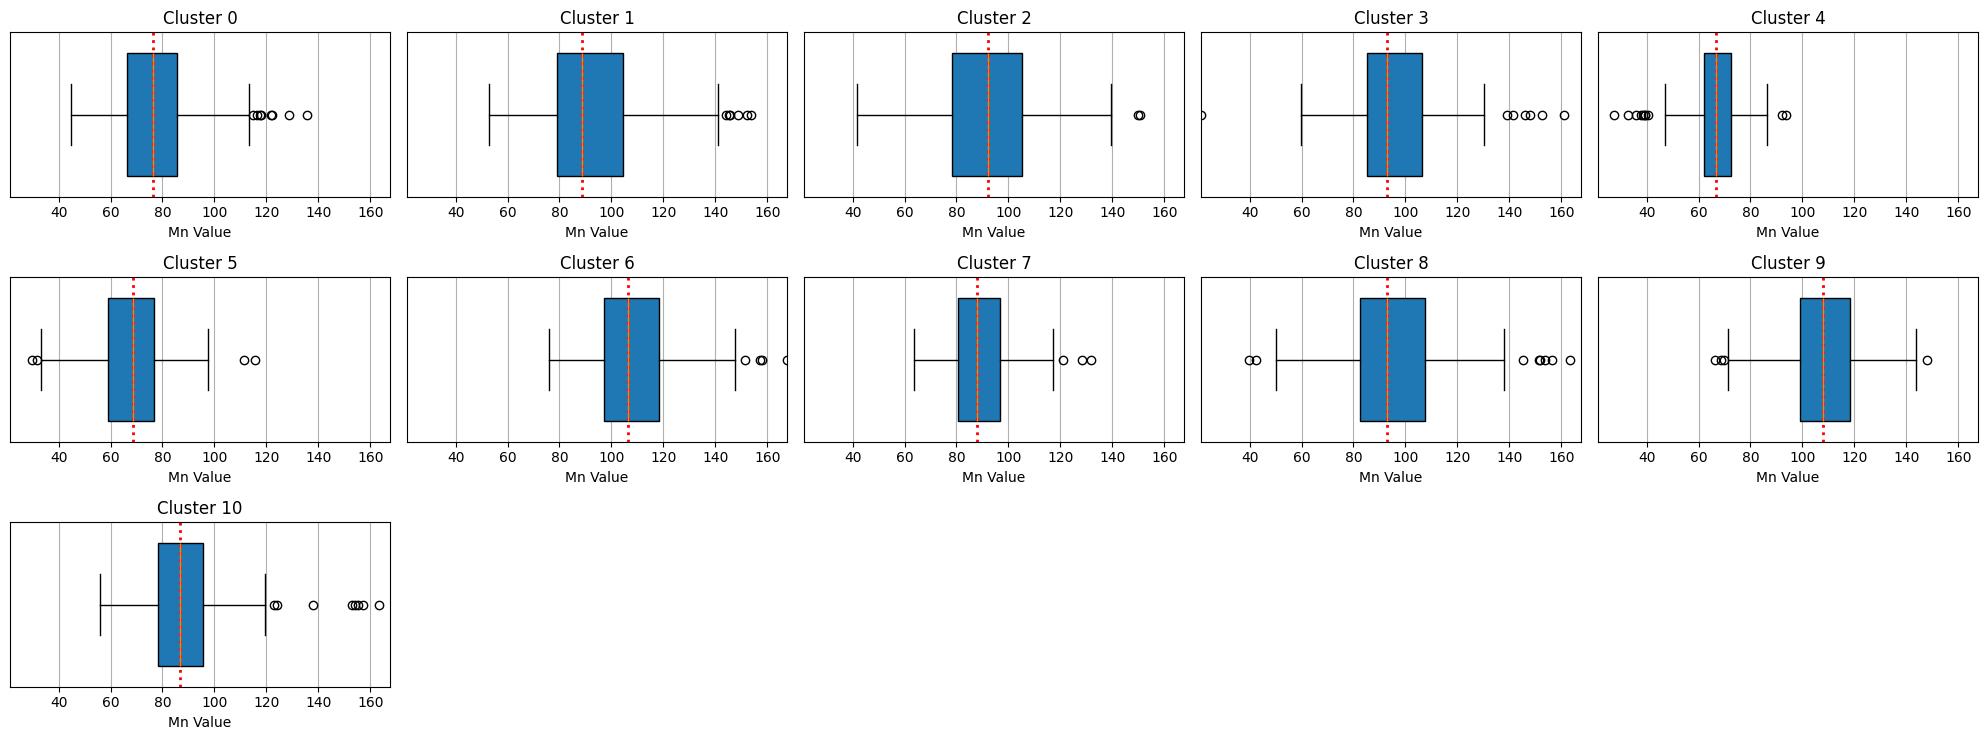

In [27]:
import matplotlib.pyplot as plt
import numpy as np


# --- Suas definições (assumindo que 'train_gt' e 'elemento' existem) ---
cluster_limits = {'x_min': train_gt[elemento].min(), 'x_max': train_gt[elemento].max()}

# 1. Pegar TODOS os clusters únicos para plotar
all_clusters = sorted(train_gt['cluster_label'].unique())
num_clusters = len(all_clusters)

# 2. Definir o layout do grid
ncols = 5
nrows = int(np.ceil(num_clusters / ncols)) 

# 3. Criar a Figura e os Eixos (subplots) UMA ÚNICA VEZ
# Podemos diminuir a altura de cada linha, já que os boxplots serão mais finos
fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 2.5)) # altura reduzida de 3 para 2.5

# 4. "Achatar" (flatten) o array de eixos
axes_flat = axes.flatten()

# 5. Loop principal (iterando pelos clusters e eixos ao mesmo tempo)
for i, cluster_to_plot in enumerate(all_clusters):
    
    # Pega o eixo (subplot) atual
    ax = axes_flat[i]
    
    # Filtra os dados do cluster
    cluster_data = train_gt[train_gt['cluster_label'] == cluster_to_plot]

    # Plotar o boxplot na horizontal
    ax.boxplot(cluster_data[elemento], vert=False, patch_artist=True)
    
    # Calcular e plotar a linha da média
    cluster_mean = cluster_data[elemento].median()
    ax.axvline(cluster_mean, color='red', linestyle='dotted', linewidth=2)
    
    # --- LINHA ADICIONADA PARA DIMINUIR A ALTURA (YLIMIT) ---
    ax.set_ylim(0.9, 1.1) # Ajuste esses valores para obter a espessura desejada
    # -----------------------------------------------------------
    
    # Configurar os eixos
    ax.set_title(f'Cluster {cluster_to_plot}')
    ax.set_xlabel(f'{elemento} Value', fontsize=10) 
    ax.set_yticks([]) 
    ax.set_xlim(cluster_limits['x_min'], cluster_limits['x_max'])
    ax.grid(True, axis='x') 

# 8. Desligar eixos extras
for j in range(num_clusters, nrows * ncols):
    axes_flat[j].axis('off')

# 9. Ajustar o layout
plt.tight_layout()

# 10. Mostrar a imagem inteira
plt.show()

In [28]:
elementos = ['B', 'Cu', 'Zn', 'Fe', 'S', 'Mn']



sample_idx = train_gt['sample_index'].nunique()


# random indexes for train (80%) and val split
np.random.seed(42)  # Para reprodutibilidade
# get 80% of sample_idx
train_indices = np.random.choice(sample_idx, size=int(0.8 * sample_idx), replace=False)
val_indices = np.setdiff1d(np.arange(sample_idx), train_indices)


elemento = 'S'
# indices for split
X_train_index = train_gt[train_gt['sample_index'].isin(train_indices)].index
X_val_index = train_gt[train_gt['sample_index'].isin(val_indices)].index

# target element for regression
y_train = train_gt.loc[X_train_index, elemento].values
y_val = train_gt.loc[X_val_index, elemento].values

# numpy views of embeddings and target
E_numpy = E.cpu().numpy()
y_numpy = train_gt[elemento].values

# split arrays
E_train = E_numpy[X_train_index]
E_val = E_numpy[X_val_index]
y_train = y_numpy[X_train_index]
y_val = y_numpy[X_val_index]


In [29]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np




# 3. Criar e treinar o modelo XGBoost
# Não precisa se preocupar com device, batches, ou normalização
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror', # Equivalente ao MSELoss
    n_estimators=200,             # Número de "árvores" (similar às épocas)
    learning_rate=0.05,
    max_depth=5,
    early_stopping_rounds=50,      # Para de treinar se a validação não melhorarplot_groups.ipynb
    n_jobs=-1                      # Usar todos os cores da CPU
)

print("Training XGBoost...")
model_xgb.fit(
    E_train, 
    y_train,
    eval_set=[(E_val, y_val)], # Usa o conjunto de validação para early stopping
    verbose=100                # Imprime o erro a cada 100 rodadas
)

# 4. Avaliar o modelo
preds = model_xgb.predict(E_val)
mse = mean_squared_error(y_val, preds)
r2 = r2_score(y_val, preds)
print(f"Validation R2: {r2:.4f}")
print(f"Validation MSE: {mse:.4f}")


Training XGBoost...
[0]	validation_0-rmse:13.36439
[100]	validation_0-rmse:10.50886
[185]	validation_0-rmse:10.52530
Validation R2: 0.4058
Validation MSE: 109.8874


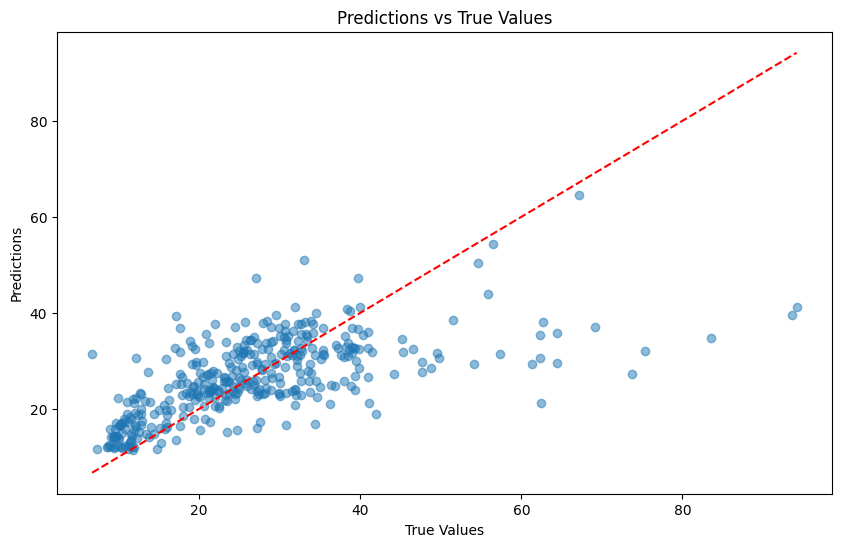

In [30]:
# plot difference between preds and y_val
plt.figure(figsize=(10, 6))
plt.scatter(y_val, preds , alpha=0.5)

# linha x= y
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')


plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.show()

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# -------------------------------------------------------
# ELEMENTOS
# -------------------------------------------------------
elementos = ['B', 'Cu', 'Zn', 'Fe', 'S', 'Mn']

# -------------------------------------------------------
# SPLIT baseado no sample_index
# -------------------------------------------------------
sample_idx = train_gt['sample_index'].nunique()

np.random.seed(42)
train_indices = np.random.choice(sample_idx, size=int(0.8 * sample_idx), replace=False)
val_indices = np.setdiff1d(np.arange(sample_idx), train_indices)

X_train_index = train_gt[train_gt['sample_index'].isin(train_indices)].index
X_val_index   = train_gt[train_gt['sample_index'].isin(val_indices)].index

# embeddings (numpy)
E_numpy = E.cpu().numpy()

# -------------------------------------------------------
# RESULTADOS
# -------------------------------------------------------
results = []

# -------------------------------------------------------
# LOOP DOS 6 ELEMENTOS
# -------------------------------------------------------
for elemento in elementos:
    print(f"\nTreinando XGBoost para {elemento}...")

    # targets
    y_numpy = train_gt[elemento].values
    y_train = y_numpy[X_train_index]
    y_val   = y_numpy[X_val_index]

    # inputs
    E_train = E_numpy[X_train_index]
    E_val   = E_numpy[X_val_index]

    # modelo
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        early_stopping_rounds=50,
        n_jobs=-1
    )

    model.fit(
        E_train, y_train,
        eval_set=[(E_val, y_val)],
        verbose=False
    )

    preds = model.predict(E_val)

    r2  = r2_score(y_val, preds)
    mae = mean_absolute_error(y_val, preds)
    rmse = np.sqrt(mean_squared_error(y_val, preds))

    results.append([elemento, r2, mae, rmse])

# -------------------------------------------------------
# TABELA DE RESULTADOS
# -------------------------------------------------------
import pandas as pd
df_results = pd.DataFrame(results, columns=["Elemento", "R2", "MAE", "RMSE"])
print("\n================ RESULTADOS =================")
print(df_results)


# save results to csv in downstream_folder_model
df_results.to_csv(downstream_folder_model + "/xgboost_results.csv", index=False)

# -------------------------------------------------------
# FIGURA COM 6 SUBPLOTS
# -------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, elemento in enumerate(elementos):
    ax = axes[i]

    # re-executar target/pred para o plot
    y_numpy = train_gt[elemento].values
    y_train = y_numpy[X_train_index]
    y_val   = y_numpy[X_val_index]
    E_train = E_numpy[X_train_index]
    E_val   = E_numpy[X_val_index]

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        early_stopping_rounds=50,
        n_jobs=-1
    )
    model.fit(E_train, y_train, eval_set=[(E_val, y_val)], verbose=False)
    preds = model.predict(E_val)

    # plot
    ax.scatter(y_val, preds, alpha=0.5)
    lim_min = min(y_val.min(), preds.min())
    lim_max = max(y_val.max(), preds.max())
    ax.plot([lim_min, lim_max], [lim_min, lim_max], 'r--')

    ax.set_title(f"{elemento}")
    ax.set_xlabel("True")
    ax.set_ylabel("Pred")

plt.tight_layout()
plt.savefig(downstream_folder_model + "/xgboost_scatter_plots.png", dpi=150, bbox_inches='tight')
plt.close(fig)


Treinando XGBoost para B...



Treinando XGBoost para Cu...

Treinando XGBoost para Zn...

Treinando XGBoost para Fe...

Treinando XGBoost para S...

Treinando XGBoost para Mn...

================ RESULTADOS =================
  Elemento        R2        MAE       RMSE
0        B  0.591977   0.113904   0.148156
1       Cu  0.329169   0.274846   0.372634
2       Zn  0.549145   0.912975   1.284041
3       Fe  0.515676  29.308134  39.025406
4        S  0.405751   6.979494  10.482721
5       Mn  0.467026  12.028528  16.473048
